# Example 4b: Discrete boson coupled to an impurity + fermionic leads

Here we model a single fermion coupled to two electronic leads or reservoirs (e.g.,  this can describe a single quantum dot, a molecular transistor, etc), also coupled to a discrete bosonic (vibronic) mode.  

Note that in this implementation we primarily follow the definitions used by Christian Schinabeck in his Dissertation https://opus4.kobv.de/opus4-fau/files/10984/DissertationChristianSchinabeck.pdf and related publications. In particular this example reproduces some results from https://journals.aps.org/prb/abstract/10.1103/PhysRevB.94.201407


Notation:  
$K=L/R$ refers to  left or right leads.

$\sigma=\pm$ refers to input/output


We choose a Lorentzian spectral density for the leads, with a peak at the chemical potential. The latter simplifies a little the notation required for the correlation functions, but can be relaxed if neccessary.

$$J(\omega) = \frac{\Gamma  W^2}{((\omega-\mu_K)^2 +W^2 )}$$


Fermi distribution is

$$f_F (x) = (\exp(x) + 1)^{-1}$$

gives correlation functions

$$C^{\sigma}_K(t) = \frac{1}{2\pi} \int_{-\infty}^{\infty} d\omega e^{\sigma i \omega t} \Gamma_K(\omega) f_F[\sigma\beta(\omega - \mu)]$$


As with the Bosonic case we can treat these with Matsubara, Pade, or fitting approaches.

The Pade decomposition approximates the Fermi distubition as 

$$f_F(x) \approx f_F^{\mathrm{approx}}(x) = \frac{1}{2} - \sum_l^{l_{max}} \frac{2k_l x}{x^2 + \epsilon_l^2}$$

$k_l$ and $\epsilon_l$ are co-efficients defined in J. Chem Phys 133,10106

Evaluating the integral for the correlation functions gives,


$$C_K^{\sigma}(t) \approx \sum_{l=0}^{l_{max}} \eta_K^{\sigma_l} e^{-\gamma_{K,\sigma,l}t}$$

where

$$\eta_{K,0} = \frac{\Gamma_KW_K}{2} f_F^{approx}(i\beta_K W)$$

$$\gamma_{K,\sigma,0} = W_K - \sigma i\mu_K$$ 

$$\eta_{K,l\neq 0} = -i\cdot \frac{k_m}{\beta_K} \cdot \frac{\Gamma_K W_K^2}{-\frac{\epsilon^2_m}{\beta_K^2} + W_K^2}$$

$$\gamma_{K,\sigma,l\neq 0}= \frac{\epsilon_m}{\beta_K} - \sigma i \mu_K$$  


The system is how described by the single impurity model coupled to a discrete bosonic mode

$$
H_{\mathrm{vib}} = H_{\mathrm{SIAM}} + \Omega a^{\dagger}a + \lambda (a+a^{\dagger})c{^\dagger}c.
$$

#### Note: This example is quite numerically challenging. For an easier introduction into the fermionic case, see example 4a.

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from qutip import *

In [3]:
import contextlib
import time

import numpy as np

from qutip import *
from qutip.nonmarkov.heom import HEOMSolver
from qutip.nonmarkov.heom import FermionicBath
from qutip.nonmarkov.heom import LorentzianBath
from qutip.nonmarkov.heom import LorentzianPadeBath

We first specify the properties of the two reservoirs, and plot their power spectra.

In [4]:
#parameters and spectra check
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)

Gamma = 0.01
W = 10**4  #Wide-band limit
T = 0.025851991 #in ev
beta = 1./T

theta = 2.
mu_l = theta/2.
mu_r = -theta/2.

w_list = np.linspace(-2,2,100)

def Gamma_L_w(w):
    return Gamma*W**2/((w-mu_l)**2 + W**2)

def Gamma_R_w(w):
    return Gamma*W**2/((w-mu_r)**2 + W**2)


def f(x):
    kB=1.
    return 1/(exp(x)+1.)
def f2(x):
    return 0.5

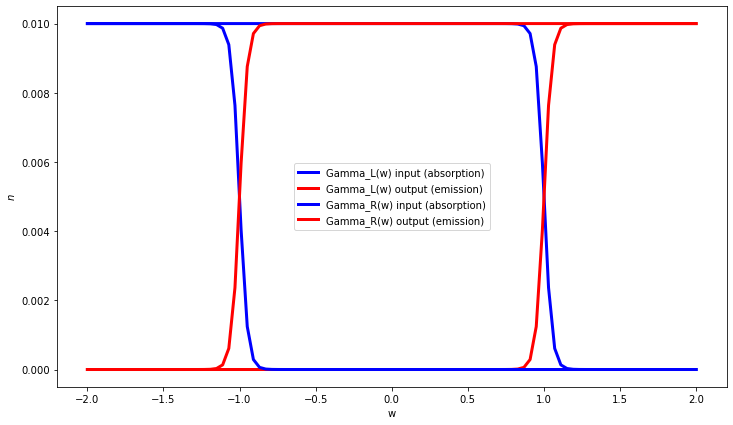

In [5]:
fig, ax1 = plt.subplots(figsize=(12, 7))
gam_list_in = [Gamma_L_w(w)*f(beta*(w-mu_l)) for w in w_list]

ax1.plot(w_list,gam_list_in, color="b", linewidth=3, label= r"Gamma_L(w) input (absorption)")

#ax1.set_ylim(0, 0.1)
ax1.set_xlabel("w")
ax1.set_ylabel(r"$n$")
ax1.legend()


gam_list_out = [Gamma_L_w(w)*f(-beta*(w-mu_l)) for w in w_list]
spec = [Gamma_L_w(w) for w in w_list]
#print(gam_list)
ax1.plot(w_list,gam_list_out, color="r", linewidth=3, label= r"Gamma_L(w) output (emission)")

gam_list_in = [Gamma_R_w(w)*f(beta*(w-mu_r)) for w in w_list]

ax1.plot(w_list,gam_list_in, color="b", linewidth=3, label= r"Gamma_R(w) input (absorption)")



gam_list_out = [Gamma_R_w(w)*f(-beta*(w-mu_r)) for w in w_list]
spec = [Gamma_R_w(w) for w in w_list]

ax1.plot(w_list,gam_list_out, color="r", linewidth=3, label= r"Gamma_R(w) output (emission)")

ax1.set_xlabel("w")
ax1.set_ylabel(r"$n$")
ax1.legend()

### Below we give one example data set from Paper

Here we just give one example of the current as a function of bias voltage, but in general one can try different cut-offs of the bosonic Fock space and the expansion of the correlation functions until convergence is found.

One note:  for very large problems, this can be slow.

In [6]:
def get_curr(theta,Nk,Ncc,Nbos):
    print("------------- theta:",theta)
    mu_l = theta/2.
    mu_r = -theta/2.


    d1 = tensor(destroy(2), qeye(Nbos))
    a = tensor(qeye(2), destroy(Nbos))

    e1 = 0.3 #d1 = spin up
    Omega = 0.2
    Lambda = 0.12

    H0 = e1*d1.dag() * d1 + Omega * a.dag()*a + Lambda * (a+a.dag()) * d1.dag() * d1

    rho_0 = tensor(basis(2,0)*basis(2,0).dag(),basis(Nbos,0)*basis(Nbos,0).dag())

 
    start = time.time()
    Q = d1
    bathL = LorentzianPadeBath(Q,Gamma,W,mu_l,T,Nk,tag="L")
    bathR = LorentzianPadeBath(Q,Gamma,W,mu_r,T,Nk,tag="R")
        # for a single impurity we converge with max_depth = 2
    resultHEOM = HEOMSolver(H0, [bathL,bathR], Ncc, options=options)
 
    end = time.time()
    print("construct time:", end - start)

    start = time.time()


    rhossHP,fullssP=resultHEOM.steady_state()
    end = time.time()
    print("Steady state time new",end - start)
    return rhossHP, fullssP
    

In [7]:
rhoHssPlistl5n2N16 = []
fullssPlistl5n2N16 = []

Nk=5

theta_list = np.linspace(0,2,30)
for theta in theta_list:
    rhotemp, fulltemp = get_curr(theta,Nk=Nk,Ncc=2,Nbos=16)
    rhoHssPlistl5n2N16.append(rhotemp)
    fullssPlistl5n2N16.append(fulltemp)
    

------------- theta: 0.0
construct time new code: 3.9088966846466064
ss time new 38.74113941192627
------------- theta: 0.06896551724137931
construct time new code: 3.829885959625244
ss time new 35.32012224197388
------------- theta: 0.13793103448275862
construct time new code: 3.810652017593384
ss time new 29.995479345321655
------------- theta: 0.20689655172413793
construct time new code: 3.829167366027832
ss time new 38.965601444244385
------------- theta: 0.27586206896551724
construct time new code: 3.7896106243133545
ss time new 35.608577489852905
------------- theta: 0.3448275862068966
construct time new code: 3.7845535278320312
ss time new 35.52901101112366
------------- theta: 0.41379310344827586
construct time new code: 3.803762674331665
ss time new 40.50437879562378
------------- theta: 0.48275862068965514
construct time new code: 3.889707326889038
ss time new 33.49233102798462
------------- theta: 0.5517241379310345
construct time new code: 3.750955820083618
ss time new 36.7

In [8]:
def state_current(ado_state,bath_tag):
        level_1_aux = [
            (ado_state.extract(label), ado_state.exps(label)[0])
            for label in ado_state.filter(level=1,tags =[bath_tag])
        ]
        def exp_sign(exp):
            return 1 if exp.type == exp.types["+"] else -1

        def exp_op(exp):
            return exp.Q if exp.type == exp.types["+"] else exp.Q.dag()

        k = Nk + 1
        return -1.0j * sum(
            exp_sign(exp) * (exp_op(exp) * aux).tr()
            for aux, exp in level_1_aux         
        )
        

currPunitsl5n2N16  = [2.434e-4*1e6*state_current(fullss,"R") for fullss in fullssPlistl5n2N16]

/tmp/ipykernel_5918/1885307037.py:13: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return -1.0j * sum(


/home/neill/anaconda3/envs/bofinexamples/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


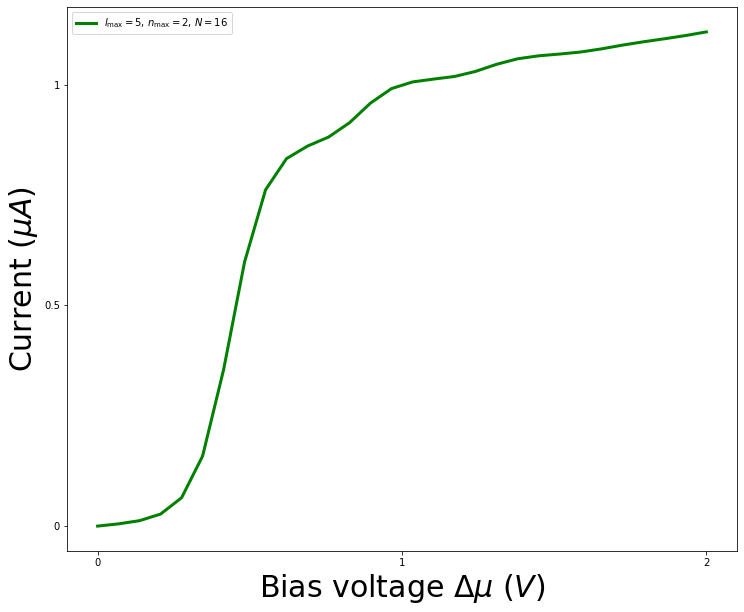

In [9]:
fig, ax1 = plt.subplots(figsize=(12, 10))

ax1.plot(theta_list,currPunitsl5n2N16, color="green", linestyle='-', linewidth=3, label= r"$l_{\mathrm{max}}=5$, $n_{\mathrm{max}}= 2$, $N = 16$")


ax1.set_yticks([0,0.5,1])
ax1.set_yticklabels([0,0.5,1])

ax1.locator_params(axis='y', nbins=4)
ax1.locator_params(axis='x', nbins=4)

ax1.set_xlabel(r"Bias voltage $\Delta \mu$ ($V$)", fontsize=30 )
ax1.set_ylabel(r"Current ($\mu A$)", fontsize=30)
ax1.legend()

/home/neill/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


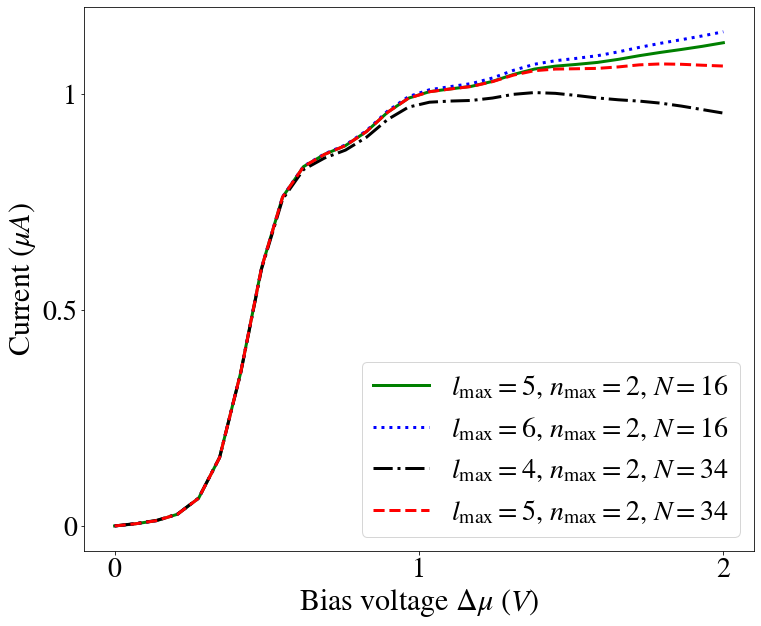

In [16]:
fig, ax1 = plt.subplots(figsize=(12, 10))


ax1.plot(theta_list,currPunitsl5n2N16, color="green", linestyle='-', linewidth=3, label= r"$l_{\mathrm{max}}=5$, $n_{\mathrm{max}} = 2$, $N = 16$")
ax1.plot(theta_list,currPunitsl6n2N16, color="blue", linestyle=':', linewidth=3, label= r"$l_{\mathrm{max}}=6$, $n_{\mathrm{max}} = 2$, $N = 16$")

ax1.plot(theta_list,currPunitsl4n2N34, color="black", linestyle='-.', linewidth=3, label= r"$l_{\mathrm{max}}=4$, $n_{\mathrm{max}}= 2$, $N = 34$")
ax1.plot(theta_list,currPunitsl5n2N34, color="red", linestyle='--', linewidth=3, label= r"$l_{\mathrm{max}}=5$, $n_{\mathrm{max}} = 2$, $N = 34$")

ax1.set_yticks([0,0.5,1])
ax1.set_yticklabels([0,0.5,1])

ax1.locator_params(axis='y', nbins=4)
ax1.locator_params(axis='x', nbins=4)

ax1.set_xlabel(r"Bias voltage $\Delta \mu$ ($V$)", fontsize=30 )
ax1.set_ylabel(r"Current ($\mu A$)", fontsize=30)
ax1.legend()
#plt.savefig("figures/figImpBos.pdf")